# Linearized Lateral model
---

For this exercise, we will reuse the `AeroDynamicsCoefficients` and `TrimCondition` objects developed in the previous exercise. 

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
from math import sin, cos
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import jdc
from ipywidgets import interactive
from scipy.stats import multivariate_normal
from Cessna import AeroDynamicsCoefficients
from Trim import TrimCondition
pylab.rcParams['figure.figsize'] = 10, 10

We will provide partially developed `LinearLateralModel` which contains equations outlined in Model.pdf.

You will go through the process of adequately integrating the given object with the `Aerodynamics` and `TrimCondition` objects from the previous exercise. 


The `LinearLateralModel` will inherit from the `AeroDynamicsCoefficients` object which will provide all the necessary constants which will need to perform the calculations.

Also, we will transfer the `TrimObject` as the variable. 

In [2]:
class LinearLateralModel(AeroDynamicsCoefficients):
    
    def __init__(self,TrimObject):
        super(LinearLateralModel, self).__init__()
        self.TrimObject = TrimObject
        
    def trim_values(self):
        v_at_trim = 68.0
        self.alpha_star = Trim.alpha_for_trim(v_at_trim)
        self.u_star = v_at_trim * np.cos(self.alpha_star) 
        self.w_star = v_at_trim * np.sin(self.alpha_star)
        self.q_star = 0.0
        self.v_a_star = v_at_trim
        
        self.delta_e_star = Trim.delta_e(self.alpha_star)
        self.delta_t_star = 0.0
        self.theta_star = self.alpha_star
        self.p_star = 0.0
        self.r_star = 0.0
        self.beta_star = 0.0
        self.delta_a_star = 0.0 
        self.delta_r_star = 0.0
        self.phi_star = 0.0


Declaring the $\Gamma$ variables according to the model.pdf page 6.

In [3]:
%%add_to LinearLateralModel

def gammas(self):
    
    gamma = self.j_x * self.j_z -self.j_xz**2
        
    self.gamma_1 = (self.j_xz * (self.j_x -self.j_y + self.j_z))/gamma
    self.gamma_2 = (self.j_z *(self.j_z - self.j_y) + self.j_xz**2)/gamma
    self.gamma_3 = self.j_z/gamma
    self.gamma_4 = self.j_xz/gamma
    self.gamma_5 = (self.j_z - self.j_x)/self.j_y
    self.gamma_6 = self.j_xz/self.j_y
    self.gamma_7 = ((self.j_x-self.j_y)*self.j_x -self.j_xz**2)/gamma
    self.gamma_8 = self.j_x/gamma

Declaring the variables according to the model.pdf page 8.

In [4]:
%%add_to LinearLateralModel

@property
def c_p_p(self):
    c_p_p = self.gamma_3 * self.c_l_p + self.gamma_4 * self.c_n_p
    return c_p_p

@property
def c_p_r(self):
    c_p_r = self.gamma_3 * self.c_l_r + self.gamma_4 * self.c_n_r
    return c_p_r 

@property 
def c_p_0(self):
    c_p_0 = self.gamma_3 * self.c_l_0 + self.gamma_4 * self.c_n_0
    return c_p_0

@property
def c_p_beta(self):
    c_p_beta = self.gamma_3 * self.c_l_beta + self.gamma_4 * self.c_n_beta
    return c_p_beta 

@property
def c_p_delta_a(self):
    c_p_delta_a= self.gamma_3 * self.c_l_delta_a + self.gamma_4 * self.c_n_delta_a
    return c_p_delta_a

@property
def c_p_delta_r(self):
    c_p_delta_r = self.gamma_3 * self.c_l_delta_r + self.gamma_4 * self.c_n_delta_r
    return c_p_delta_r

@property
def c_r_p(self):
    c_r_p = self.gamma_4 * self.c_l_p + self.gamma_8 * self.c_n_p
    return c_r_p

@property
def c_r_r(self):
    c_r_r = self.gamma_4 * self.c_l_r + self.gamma_8 * self.c_n_r
    return c_r_r

@property
def c_r_0(self):
    c_r_0 = self.gamma_4 * self.c_l_0 + self.gamma_8 * self.c_n_0
    return c_r_0

@property
def c_r_beta(self):
    c_r_beta = self.gamma_4 * self.c_l_beta + self.gamma_8 * self.c_n_beta
    return c_r_beta

@property
def c_r_delta_a(self):
    c_r_delta_a = self.gamma_4 * self.c_l_delta_a + self.gamma_8 * self.c_n_delta_a
    return c_r_delta_a

@property
def c_r_delta_r(self):
    c_r_delta_r = self.gamma_4 * self.c_l_delta_r + self.gamma_8 * self.c_n_delta_r
    return c_r_delta_r

Formulating the matrix variables for Linearized Longitudinal model outlined on page 6.

In [5]:
%%add_to LinearLateralModel

@property
def y_v(self):
    y_v = self.rho * self.s * self.b * self.v_a_star/ (4* self.mass * self.v_a_star) \
          * (self.c_y_p * self.p_star + self.c_y_r * self.r_star) \
          + self.rho * self.s * self. v_a_star /self.mass * (self.c_y_0 + self.c_y_beta * self.beta_star \
          + self.c_y_delta_a * self.delta_a_star + self.c_y_delta_r * self.delta_r_star) \
        + self.rho * self.s * self.c_y_beta/ (2* self.mass) * np.sqrt(self.u_star**2 + self.w_star**2)
    return y_v


@property
def y_p(self):
    y_p = self.w_star + self.rho * self.v_a_star * self.s * self.b /(4 * self.mass) * self.c_y_p
    return y_p

@property
def y_r(self):
    y_r = -self.u_star +self.rho * self.v_a_star * self.s * self.b /(4 * self.mass) * self.c_y_r
    return y_r 

@property 
def y_delta_a(self):
    y_delta_a = self.rho * self.v_a_star**2 * self.s /(2 * self.mass) * self.c_y_delta_alpha
    return y_delta_a

@property
def y_delta_r(self):
    y_delta_r = self.rho * self.v_a_star**2 * self.s /(2 * self.mass) * self.c_y_delta_r
    return y_delta_r

@property
def l_v(self):
    
    l_v = self.rho * self.s * self.b**2 * self.v_a_star / (4 * self.v_a_star) * (self.c_p_p * self.p_star + self.c_p_r * self.r_star) \
        + self.rho * self.s * self.b * self.v_a_star \
        * (self.c_p_0 + self.c_p_beta * self.beta_star + self.c_p_delta_a * self.delta_a_star + self.c_p_delta_r * self.delta_r_star)\
        + self.rho * self.s * self.b * self.c_p_beta * np.sqrt(self.u_star**2 + self.w_star**2)/2
    return l_v 

@property
def l_p(self):
    l_p = self.gamma_1 * self.q_star + self.rho * self.v_a_star *self.s * self.b**2 /4 * self.c_p_p
    return l_p

@property
def l_r(self):
    l_r = -self.gamma_2 * self.q_star + self.rho * self.v_a_star * self.s * self.b**2 /4 * self.c_p_r
    return l_r

@property
def l_delta_a(self):
    l_delta_a = self.rho * self.v_a_star**2 * self.s * self.b /2 * self.c_p_delta_a
    return l_delta_a 

@property
def l_delta_r(self):
    l_delta_r = self.rho * self.v_a_star**2 * self.s * self.b /2 * self.c_p_delta_r 
    return l_delta_r

@property
def n_v(self):
    n_v = self.rho * self.s * self.b**2 * self.v_a_star /(4 * self.v_a_star) * (self.c_r_p * self.p_star + self.c_r_r * self.r_star)\
        + self.rho * self.s * self.b    * self.v_a_star * (self.c_r_0 + self.c_r_beta * self.beta_star \
        + self.c_r_delta_a * self.delta_a_star + self.c_r_delta_r * self.delta_r_star)\
        + self.rho * self.s * self.b * self.c_r_beta /2 * np.sqrt(self.u_star**2 + self.w_star**2)
    return n_v 

@property
def n_p(self):
    n_p = self.gamma_7 * self.q_star + self.rho * self.v_a_star * self.s * self.b**2 /4 * self.c_r_p 
    return n_p 

@property
def n_r(self):
    n_r = -self.gamma_1 * self.q_star + self.rho * self.v_a_star * self.s * self.b**2/4 * self.c_r_r 
    return n_r

@property
def n_delta_a(self):
    n_delta_a = self.rho * self.v_a_star**2 * self.s * self.b /2 * self. c_r_delta_a
    return n_delta_a 

@property
def n_delta_r(self):
    n_delta_r = self.rho * self.v_a_star**2 * self.s * self.b /2 * self.c_r_delta_r 
    return n_delta_r

Declaring the matrix describing the linearized lateral model.

In [6]:
%%add_to LinearLateralModel

def state_space_matrix(self):
    
    self.ss_matrix_model = np.array([[self.y_v, self.y_p/(self.v_a_star * np.cos(self.beta_star)), self.y_r/(self.v_a_star * np.cos(self.beta_star)),
                              self.g * np.cos(self.theta_star) * np.cos(self.phi_star)/ (self.v_a_star * np.cos(self.beta_star)), 0.0 ],
                               [self.l_v * self.v_a_star * np.cos(self.beta_star), self.l_p, self.l_r, 0.0, 0.0],
                               [self.n_v * self.v_a_star * np.cos(self.beta_star), self.n_p, self.n_r, 0.0, 0.0],
                               [0.0, 1.0, np.cos(self.phi_star) * np.tan(self.theta_star), self.q_star * np.cos(self.phi_star)* np.tan(self.theta_star)\
                                -self.r_star * np.sin(self.phi_star) * np.tan(self.theta_star), 0.0 ],
                               [0.0, 0.0, np.cos(self.phi_star)/np.cos(self.theta_star), self.p_star * np.cos(self.phi_star)/np.cos(self.theta_star)\
                               -self.r_star * np.sin(self.phi_star)/np.cos(self.theta_star),0.0 ]])
    
    return self.ss_matrix_model

In [7]:
# Initialize the TrimCondition object
Trim = TrimCondition()

# Initialize the LinearLateralModel object with Trim object which has been initialized in the previous line
v = 68.0 # If v is too large, then the oscillations will not occur 
LSS = LinearLateralModel(Trim)

# Calculate the trim condition for the LinearLateralModel object. 
# This will set the object variables associated with the trim to a correct values 
LSS.trim_values()

# Calculate the matrix capturing the linearized lateral model for the given parameters and the velocity 
LSS.gammas()
lss_matrix = LSS.state_space_matrix()

np.set_printoptions(precision=4)

Calculate the eigenvalues from the matrix obtained from the previous cell you can use [`np.linalg.eigvals`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.eigvals.html).

In [8]:
lambdas = np.linalg.eigvals(lss_matrix)

for i in range(lambdas.shape[0]):
    print('eigenvalue ',i, ' = ',lambdas[i])

eigenvalue  0  =  0j
eigenvalue  1  =  (-15.6886889107+0j)
eigenvalue  2  =  (-0.9023538096+3.51588311707j)
eigenvalue  3  =  (-0.9023538096-3.51588311707j)
eigenvalue  4  =  (-0.00982568162624+0j)


In order for the forward simulation to work all eigenvalues needs to be negative. At this point both model.pdf and the UAV book based method give the same answer. The next step is to change the parameters from UAV to Cessna 172 which will change the eigen values. 

# Forward simulate the linear model
---

In the given part you will forward simulate your linear system. 
The state vector is given as: 

$$
X= \begin{bmatrix} \bar{\beta} \\ \bar{p} \\ \bar{r} \\ \bar{\phi} \\ \bar{\psi}\end{bmatrix} 
$$

where: 
* $\bar{\beta}$ is side slip angle. 
* $\bar{p}$ is angular velocity along the $x$ axis
* $\bar{r}$ is angular velocity along the $z$ axis
* $\bar{\phi}$ is angle along the $x$ axis
* $\bar{\psi}$ is angle along the $z$ axis


In [9]:
total_time = 20
dt = 0.01

state_vector = np.array([0.0, 0.01, 0.00, 0.1, 0.0])
state_vector_history = state_vector

for _ in range(int(total_time/dt)):
    dot_state_vector = lss_matrix @ state_vector
    state_vector += dot_state_vector * dt
    state_vector_history = np.vstack((state_vector_history, state_vector))

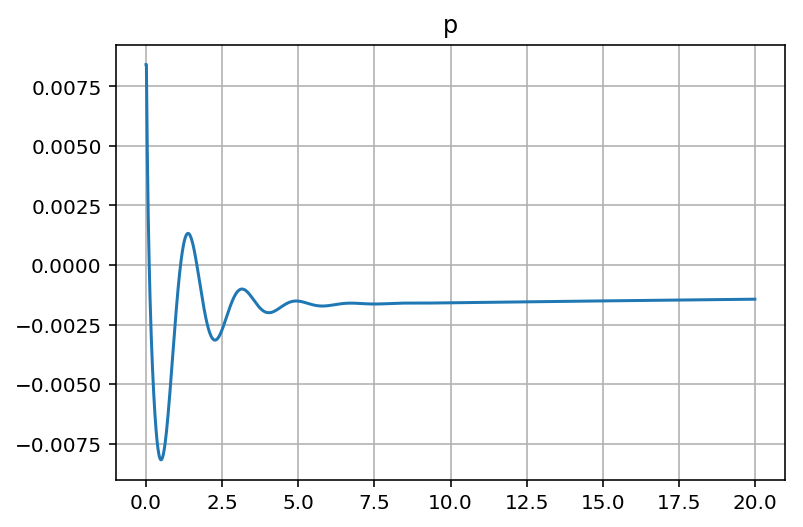

In [10]:
plt.plot(np.arange(0,total_time,dt),state_vector_history[:-1,1])
plt.title('p')
plt.grid()
plt.show()

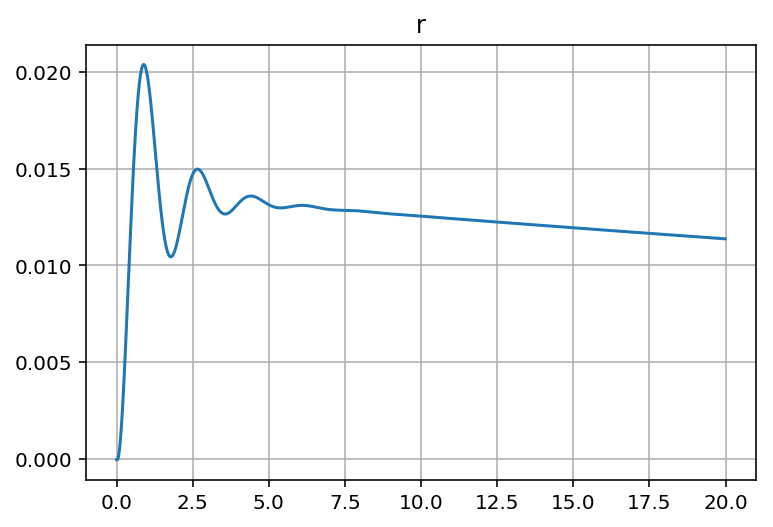

In [11]:
plt.plot(np.arange(0,total_time,dt),state_vector_history[:-1,2])
plt.title('r')
plt.grid()
plt.show()

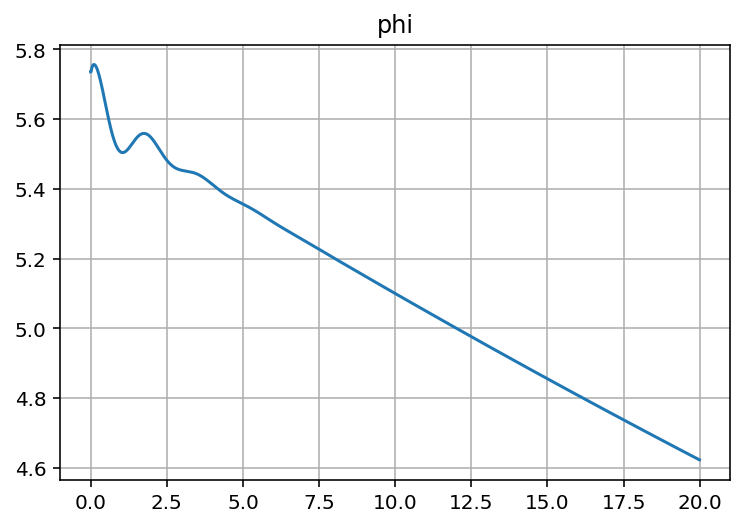

In [12]:
plt.plot(np.arange(0,total_time,dt),state_vector_history[:-1,3]/np.pi*180)
plt.title('phi')
plt.grid()
plt.show()